## Описание данных

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:

`steel.data_arc` — данные об электродах;

`steel.data_bulk` — данные об объёме сыпучих материалов;

`steel.data_bulk_time` — данные о времени подачи сыпучих материалов;

`steel.data_gas` — данные о продувке сплава газом;

`steel.data_temp` — данные об измерениях температуры;

`steel.data_wire` — данные об объёме проволочных материалов;

`steel.data_wire_time` — данные о времени подачи проволочных материалов.

## Загрузка данных

In [1]:
### импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from datetime import time
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import time as t
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

In [2]:
### зафиксируем рандом
RANDOM_STATE = 260623

In [3]:
### конфигурация подключения
db_config = {
'user': 'praktikum_student', # имя пользователя
'pwd': 'Sdf4$2;d-d30pp', # пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения
'db': 'data-science-final' # название базы данных,
}
### подключение к базе
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
### движок подключения к базе
engine = create_engine(connection_string) 

## Исследовательский анализ и предобработка данных

In [4]:
### создадим функцию для открытия и просмотра общих сведений
def df_info(name, df):
    display(name)
    display(df.head(3))
    df.info()
    display('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _')

### Таблица steel.data_arc

In [5]:
### срез для таблицы steel.data_arc
query_1 = '''
SELECT *
FROM steel.data_arc;
'''
### преобразование в табличную форму библиотеки пандас
df_1 = pd.read_sql_query(query_1, con=engine) 
df_info('steel.data_arc', df_1)

'steel.data_arc'

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

In [6]:
### просмотр общих данных таблицы
display(df_1.describe())
### выявление партии с аномальным значением
abnormal = df_1[df_1['ReactivePower']==df_1['ReactivePower'].min()]
abnormal_key = int(abnormal['key'])
abnormal_query = df_1.query('key == @abnormal_key')
display(abnormal_query)
### рассчитаем среднее значение, на которое затухало значение в столбце ReactivePower
abnormal_query_min = abnormal_query['ReactivePower'].min()
abnormal_query = abnormal_query.loc[(abnormal_query['ReactivePower'] != abnormal_query_min)]
abnormal_query['col_diff'] = abnormal_query['ActivePower'] - abnormal_query['ReactivePower']
col_diff_mean = abnormal_query['col_diff'].mean()
display('Привиденное значение для замены равно:', col_diff_mean)

,key,ActivePower,ReactivePower
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


,key,BeginHeat,EndHeat,ActivePower,ReactivePower
9779,2116,00:29:52,00:31:54,0.433266,0.306141
9780,2116,00:35:50,00:38:05,0.620265,0.408352
9781,2116,00:44:48,00:46:37,0.495782,-715.504924
9782,2116,00:51:51,00:52:58,0.299368,0.198796


'Привиденное значение для замены равно:'

0.14653675240000003

In [7]:
### заменим аномальное значение и повторно выведем описание данных
df_1['ReactivePower'] = df_1['ReactivePower'].replace (abnormal_query_min, col_diff_mean)
df_1.describe()

,key,ActivePower,ReactivePower
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.500700
std,934.571502,0.408159,0.310884
min,1.000000,0.030002,0.020806
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [8]:
### создадим словарь значений
dict_cnt_keys = df_1['key'].value_counts().sort_index().to_dict()
### подготовим функцию
def cnt_observation(row):
    x = row['key']
    y = dict_cnt_keys.get(x)
    return y
### применим функцию
df_1['cnt_observations'] = df_1.apply(cnt_observation, axis=1)
df_1.head(3)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,cnt_observations
0,1,11:02:14,11:06:02,0.976059,0.687084,5
1,1,11:07:28,11:10:33,0.805607,0.520285,5
2,1,11:11:44,11:14:36,0.744363,0.498805,5


In [9]:
### создадим новые признаки
df_1['BeginHeat'] = pd.to_datetime(df_1['BeginHeat'].astype(str), format='%H:%M:%S')
df_1['EndHeat'] = pd.to_datetime(df_1['EndHeat'].astype(str), format='%H:%M:%S')
df_1['time_heat_sec'] = (df_1['EndHeat'] - df_1['BeginHeat']).dt.seconds
df_1['power_diff'] = df_1['ActivePower'] - df_1['ReactivePower']
df_1['power_sum'] = df_1['ActivePower'] + df_1['ReactivePower']
df_1['div_act_react'] = df_1['ActivePower'] / df_1['ReactivePower']
df_1.head(5)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,cnt_observations,time_heat_sec,power_diff,power_sum,div_act_react
0,1,1900-01-01 11:02:14,1900-01-01 11:06:02,0.976059,0.687084,5,228,0.288975,1.663142,1.420582
1,1,1900-01-01 11:07:28,1900-01-01 11:10:33,0.805607,0.520285,5,185,0.285322,1.325892,1.548395
2,1,1900-01-01 11:11:44,1900-01-01 11:14:36,0.744363,0.498805,5,172,0.245558,1.243169,1.492292
3,1,1900-01-01 11:18:14,1900-01-01 11:24:19,1.659363,1.062669,5,365,0.596693,2.722032,1.561504
4,1,1900-01-01 11:26:09,1900-01-01 11:28:37,0.692755,0.414397,5,148,0.278358,1.107152,1.671717


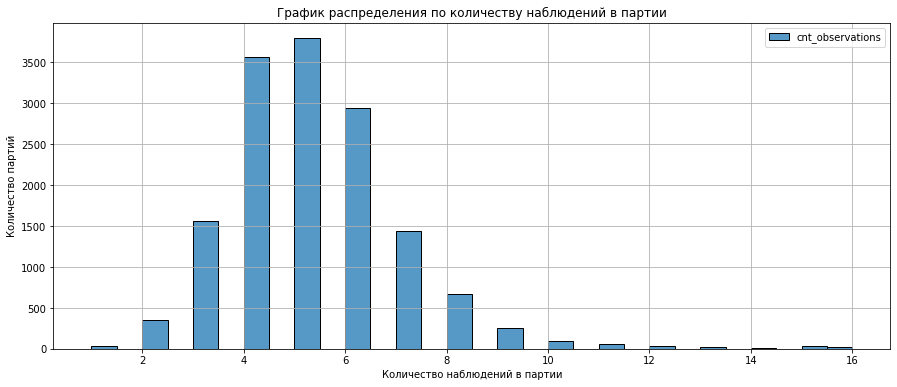

In [10]:
### посмотрим график распределения по количеству наблюдений в партии
plt.figure(figsize=(15,6))
ax_0 = sns.histplot(data=df_1[['cnt_observations']], binwidth=0.5)
ax_0.set_xlabel('Количество наблюдений в партии')
ax_0.set_ylabel('Количество партий')
plt.title('График распределения по количеству наблюдений в партии')
plt.grid()
plt.show()

In [11]:
### посмотрим корреляцию между мощностями
df_1_corr = df_1[['ActivePower', 'ReactivePower']].corr()
df_1_corr

,ActivePower,ReactivePower
ActivePower,1.000000,0.963167
ReactivePower,0.963167,1.000000


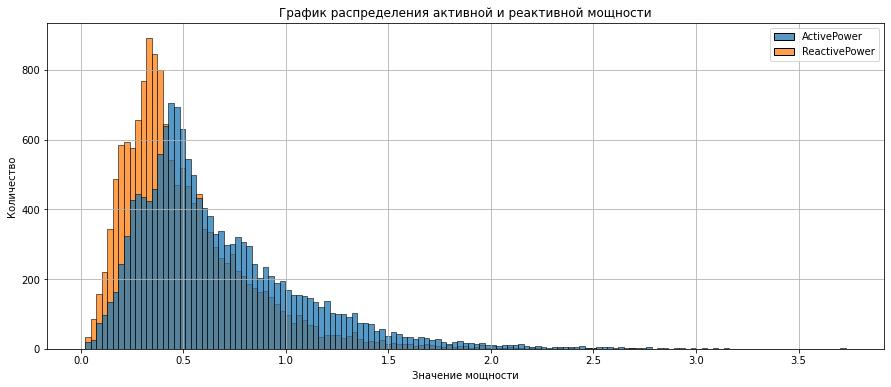

In [12]:
### построим график распределения активной и реактивной мощности
plt.figure(figsize=(15,6))
ax_1 = sns.histplot(data=df_1[['ActivePower', 'ReactivePower']])
ax_1.set_xlabel('Значение мощности')
ax_1.set_ylabel('Количество')
plt.title('График распределения активной и реактивной мощности')
plt.grid()
plt.show()

In [13]:
### скорректируем названия колонок, для корректного соединения таблиц в дальнейшем
df_1.columns = ['key', 'begin_heat', 'end_heat', 'active_power', 'reactive_power','cnt_observations', 
                'time_heat_sec', 'power_diff', 'power_sum', 'div_act_react']
df_1.head(1)

,key,begin_heat,end_heat,active_power,reactive_power,cnt_observations,time_heat_sec,power_diff,power_sum,div_act_react
0,1,1900-01-01 11:02:14,1900-01-01 11:06:02,0.976059,0.687084,5,228,0.288975,1.663142,1.420582


#### Вывод

- Данные в таблице корректны, пропусков нет. 
- Аномальное значение заменено на среднее изменение мощности в данной партии.
- Добавлены новые признаки: количество запусков нагрева, время наблюдения, разница мощностей, суммарная мощность, соотношение мощностей.
- Между мощностями высокая положительная корреляция, со значением равным 0.963
- На графике заметна корреляция между активной и реактивной мощностью.

### Таблица steel.data_bulk

In [14]:
### срез для таблицы steel.data_bulk
query_2 = '''
SELECT *
FROM steel.data_bulk;
'''
### преобразование в табличную форму библиотеки пандас
df_2 = pd.read_sql_query(query_2, con=engine) 
df_info('steel.data_bulk', df_2)

'steel.data_bulk'

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

In [15]:
### заполнение пропусков нулем
df_2 = df_2.fillna(0)
### выведем колонки в отдельную переменную
df_2_cols = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 
             'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']
df_2['bulk_sum'] = df_2[df_2_cols].sum(axis=1)
### просмотр общих данных таблицы
display(df_2.describe())
display(df_2.info())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_sum
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271,595.503356
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698,276.557794
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000,429.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000,591.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000,772.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,3235.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   key       3129 non-null   int64  
 1   Bulk 1    3129 non-null   float64
 2   Bulk 2    3129 non-null   float64
 3   Bulk 3    3129 non-null   float64
 4   Bulk 4    3129 non-null   float64
 5   Bulk 5    3129 non-null   float64
 6   Bulk 6    3129 non-null   float64
 7   Bulk 7    3129 non-null   float64
 8   Bulk 8    3129 non-null   float64
 9   Bulk 9    3129 non-null   float64
 10  Bulk 10   3129 non-null   float64
 11  Bulk 11   3129 non-null   float64
 12  Bulk 12   3129 non-null   float64
 13  Bulk 13   3129 non-null   float64
 14  Bulk 14   3129 non-null   float64
 15  Bulk 15   3129 non-null   float64
 16  bulk_sum  3129 non-null   float64
dtypes: float64(16), int64(1)
memory usage: 415.7 KB


None

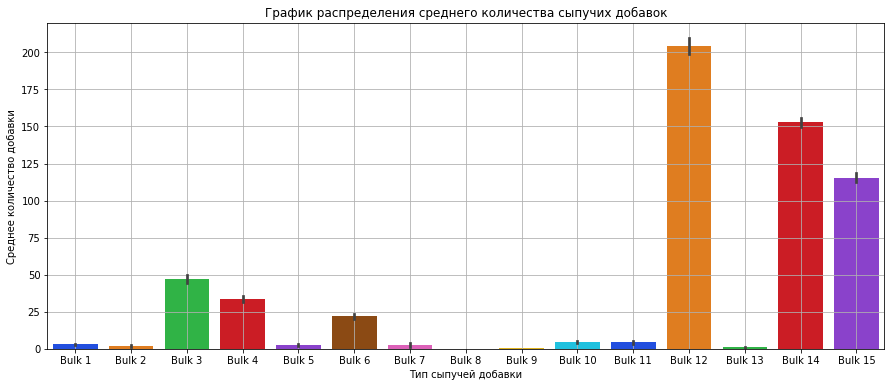

In [16]:
### построим график распределения
plt.figure(figsize=(15,6))
ax_2 = sns.barplot(data=df_2.drop(['key', 'bulk_sum'], axis=1), palette='bright')
ax_2.set_xlabel('Тип сыпучей добавки')
ax_2.set_ylabel('Среднее количество добавки')
plt.title('График распределения среднего количества сыпучих добавок')
plt.grid()
plt.show()

In [17]:
### скорректируем названия колонок, для корректного соединения таблиц в дальнейшем
df_2.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 
                'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'bulk_sum']
df_2 = df_2.set_index('key')
df_2.head(1)

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum
key,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0


#### Вывод

- В данных очень много пропусков. 
- Добавка из сыпучих матриеалов под номером 8, например, добавлялась лишь в одной партии.
- Пропуск в данных означает отсутсвие добавки.
- Для упрощения расчетов, пропуски заполнены нулем.
- Наибольшее количество из добавляемых сыпучих материалов у номера 12.

### Таблица steel.data_bulk_time

In [18]:
### срез для таблицы steel.data_bulk_time
query_3 = '''
SELECT *
FROM steel.data_bulk_time;
'''
### преобразование в табличную форму библиотеки пандас
df_3 = pd.read_sql_query(query_3, con=engine) 
df_info('steel.data_bulk_time', df_3)

'steel.data_bulk_time'

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

In [19]:
### проверка на адекватность
plug = time()
df_3 = df_3.fillna(plug)
### создание столбца с максимальным значением в строке
df_3['max_time_bulk'] = df_3[df_2_cols].max(axis=1)
### создание столбца с минимальным значением не равным заглушке
def second_min(x):
    list_val = []
    for i in range(1, 16):   
        k = x[f'Bulk {i}']
        if k != plug:
            list_val.append(k)       
    a = min(list_val)
    return a
df_3['min_time_bulk'] = df_3[df_2_cols].apply(second_min, axis=1)
df_3['max_time_bulk'] = pd.to_datetime(df_3['max_time_bulk'].astype(str), format='%H:%M:%S')
df_3['min_time_bulk'] = pd.to_datetime(df_3['min_time_bulk'].astype(str), format='%H:%M:%S')
df_3['time_dif_sec_bulk'] = (df_3['max_time_bulk'] - df_3['min_time_bulk']).dt.seconds
display(df_3.head(3))
### скорректируем названия колонок, для корректного соединения таблиц в дальнейшем
df_3.columns = ['key', 'bulk_1_time', 'bulk_2_time', 'bulk_3_time', 'bulk_4_time', 'bulk_5_time', 'bulk_6_time', 
                'bulk_7_time', 'bulk_8_time', 'bulk_9_time', 'bulk_10_time', 'bulk_11_time', 'bulk_12_time', 'bulk_13_time', 
                'bulk_14_time', 'bulk_15_time', 'max_time_bulk', 'min_time_bulk', 'time_dif_sec_bulk']
df_3 = df_3.set_index('key')
### выведем строку с максимальным значением для проверки адекватности
max_val_time_dif = df_3['time_dif_sec_bulk'].max()
display(df_3.loc[(df_3['time_dif_sec_bulk'] == max_val_time_dif)])

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,max_time_bulk,min_time_bulk,time_dif_sec_bulk
0,1,00:00:00,00:00:00,00:00:00,11:21:30,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,11:03:52,00:00:00,11:03:52,11:03:52,1900-01-01 11:21:30,1900-01-01 11:03:52,1058
1,2,00:00:00,00:00:00,00:00:00,11:46:38,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,11:40:20,00:00:00,11:40:20,11:40:20,1900-01-01 11:46:38,1900-01-01 11:40:20,378
2,3,00:00:00,00:00:00,00:00:00,12:31:06,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,12:09:40,00:00:00,12:09:40,12:09:40,1900-01-01 12:31:06,1900-01-01 12:09:40,1286


,bulk_1_time,bulk_2_time,bulk_3_time,bulk_4_time,bulk_5_time,bulk_6_time,bulk_7_time,bulk_8_time,bulk_9_time,bulk_10_time,bulk_11_time,bulk_12_time,bulk_13_time,bulk_14_time,bulk_15_time,max_time_bulk,min_time_bulk,time_dif_sec_bulk
key,,,,,,,,,,,,,,,,,,
1735,00:00:00,00:00:00,00:00:00,00:02:16,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,23:58:54,00:00:00,23:58:54,23:58:54,1900-01-01 23:58:54,1900-01-01 00:02:16,86198


#### Вывод

- В данных очень много пропусков, но они идентичны таблице `steel.data_bulk`.
- Добавка под номером 8, добавлялась лишь в одной партии, аналогично с предыдущей таблицей.
- Пропуски заполнены заглушкой `00:00:00`.
- Данные проверены на адекватность, наибольшее значение разницы не превышает суток.
- Полученное максимальное значение показало 23 часа между сыпучими материалами, но это из-за формата времени без конкретной даты, поэтому все адекватно.

### Таблица steel.data_gas

In [20]:
### срез для таблицы steel.data_gas
query_4 = '''
SELECT *
FROM steel.data_gas;
'''
### преобразование в табличную форму библиотеки пандас
df_4 = pd.read_sql_query(query_4, con=engine) 
df_info('steel.data_gas', df_4)

'steel.data_gas'

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

In [21]:
### просмотр общих данных таблицы
df_4 = df_4.set_index('key')
display(df_4.describe())

,gas
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


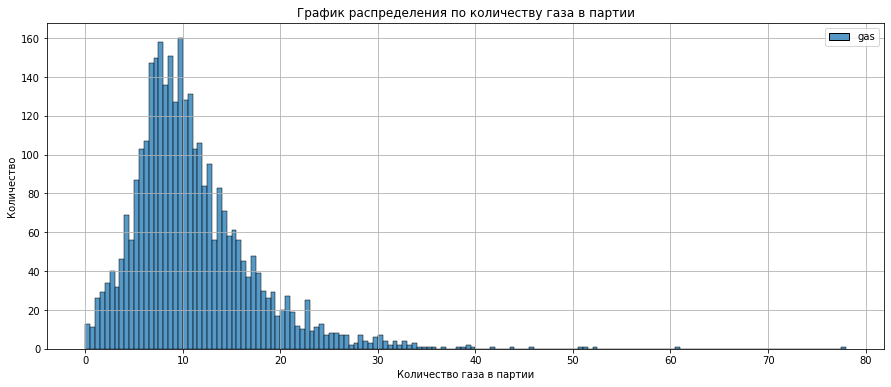

In [22]:
### посмотрим график распределения по количеству газа в партии
plt.figure(figsize=(15,6))
ax_4 = sns.histplot(data=df_4[['gas']], binwidth=0.5)
ax_4.set_xlabel('Количество газа в партии')
ax_4.set_ylabel('Количество')
plt.title('График распределения по количеству газа в партии')
plt.grid()
plt.show()

#### Вывод

- Количество газа указано суммарное, для каждой партии, т.е. количество продувок нам неизвестно.
- Пропусков в данных нет.
- Аномалии не обнаружены.
- Самый частый объем газа для продувки - около 6-8 условных единиц.

### Таблица steel.data_temp

In [23]:
### срез для таблицы steel.data_temp
query_5 = '''
SELECT *
FROM steel.data_temp AS sdt;
'''
### преобразование в табличную форму библиотеки пандас
df_5 = pd.read_sql_query(query_5, con=engine) 
df_info('steel.data_temp', df_5)

'steel.data_temp'

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

In [24]:
### просмотр общих данных таблицы
display(df_5.describe())

,key,Temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


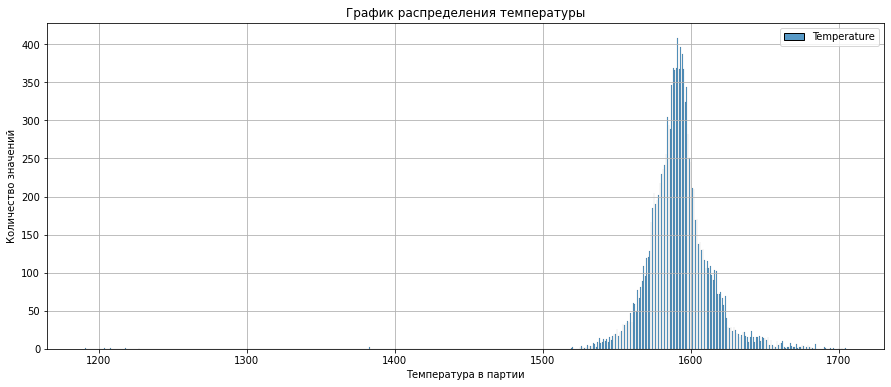

In [25]:
### посмотрим график распределения по количеству газа в партии
plt.figure(figsize=(15,6))
ax_5 = sns.histplot(data=df_5[['Temperature']], binwidth=0.5)
ax_5.set_xlabel('Температура в партии')
ax_5.set_ylabel('Количество значений')
plt.title('График распределения температуры')
plt.grid()
plt.show()

In [26]:
### определим партии без температуры
df_5_query = df_5[df_5.isnull().any(1)]
bad_parties = list(df_5_query['key'].unique())
cnt_bad_parties = len(df_5_query['key'].unique())
cnt_parties = df_5['key'].max()
display(f'Количество партий без значений температуры: {cnt_bad_parties}, или {round((cnt_bad_parties/cnt_parties)*100,2)}%')

'Количество партий без значений температуры: 739, или 22.8%'

In [27]:
### ранжируем значения для последующей обработки
df_5['index_int'] = df_5.index
df_5['temp_rank'] = df_5.groupby(['key'])['index_int'].rank()
### создадим словарь значений
dict_cnt_keys_5 = df_5['key'].value_counts().sort_index().to_dict()
### подготовим функцию
def cnt_observation_2(row):
    x = row['key']
    y = dict_cnt_keys_5.get(x)
    return y
### применим функцию
df_5['cnt_observations'] = df_5.apply(cnt_observation_2, axis=1)
### присвоим названия первым и последним партиям
def str_rank(row):
    a = row['temp_rank']
    b = row['cnt_observations']
    c = None
    if a == 1:
        c = 'first'
    if a == b:
        c = 'last'
    return c
### применим функцию и уберем лишние столбцы    
df_5['str_rank'] = df_5.apply(str_rank, axis=1)
df_5 = df_5.drop(['index_int', 'temp_rank', 'cnt_observations'], axis=1)
df_5.head(11)

,key,MesaureTime,Temperature,str_rank
0,1,11:16:18,1571.0,first
1,1,11:25:53,1604.0,None
2,1,11:29:11,1618.0,None
3,1,11:30:01,1601.0,None
4,1,11:30:39,1613.0,last
5,2,11:37:27,1581.0,first
6,2,11:38:00,1577.0,None
7,2,11:49:38,1589.0,None
8,2,11:55:50,1604.0,None
9,2,11:58:24,1608.0,None


In [28]:
### в соотвествии с условием заказчика уберем аномальные значени и плохие партии
df_5_query_2 = df_5.query("Temperature > 1500 and key not in @bad_parties").dropna()
display(df_5_query_2.tail(4))
display(df_5_query_2.info())

,key,MesaureTime,Temperature,str_rank
12259,2498,02:03:49,1591.0,first
12263,2498,02:25:31,1594.0,last
12264,2499,02:40:25,1569.0,first
12266,2499,03:00:28,1603.0,last


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4948 entries, 0 to 12266
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          4948 non-null   int64  
 1   MesaureTime  4948 non-null   object 
 2   Temperature  4948 non-null   float64
 3   str_rank     4948 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 193.3+ KB


None

In [29]:
### скорректируем названия колонок, для корректного соединения таблиц в дальнейшем
df_5_query_2.columns = ['key', 'mesaure_time', 'temperature', 'str_rank']
df_5_query_2.head(1)

,key,mesaure_time,temperature,str_rank
0,1,11:16:18,1571.0,first


#### Вывод

- По условию заказчика аномальные партии с температурой ниже 1500 градусов - удалены.
- Всего плохих партий - 739 шт, или приблизительно 23%.
- Промежуточные строки с значениями температуры удалены, так как для использования в дальнейшем потребуются только начальные и конечные значения. 
- Наиболее частое значение температуры находится в пределах от 1580 до 1590 градусов.

### Таблица steel.data_wire

In [30]:
### срез для таблицы steel.data_wire
query_6 = '''
SELECT *
FROM steel.data_wire;
'''
### преобразование в табличную форму библиотеки пандас
df_6 = pd.read_sql_query(query_6, con=engine) 
df_info('steel.data_wire', df_6)

'steel.data_wire'

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

In [31]:
### заполнение пропусков нулем
df_6 = df_6.fillna(0)
### выведем колонки в отдельную переменную
df_6_cols = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
df_6['wire_sum'] = df_6[df_6_cols].sum(axis=1)
### просмотр общих данных таблицы
display(df_6.describe())
display(df_6.info())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_sum
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492,123.723326
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904,66.082966
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.918800
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,86.112000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,114.179523
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.181198
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604,663.851766


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   key       3081 non-null   int64  
 1   Wire 1    3081 non-null   float64
 2   Wire 2    3081 non-null   float64
 3   Wire 3    3081 non-null   float64
 4   Wire 4    3081 non-null   float64
 5   Wire 5    3081 non-null   float64
 6   Wire 6    3081 non-null   float64
 7   Wire 7    3081 non-null   float64
 8   Wire 8    3081 non-null   float64
 9   Wire 9    3081 non-null   float64
 10  wire_sum  3081 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 264.9 KB


None

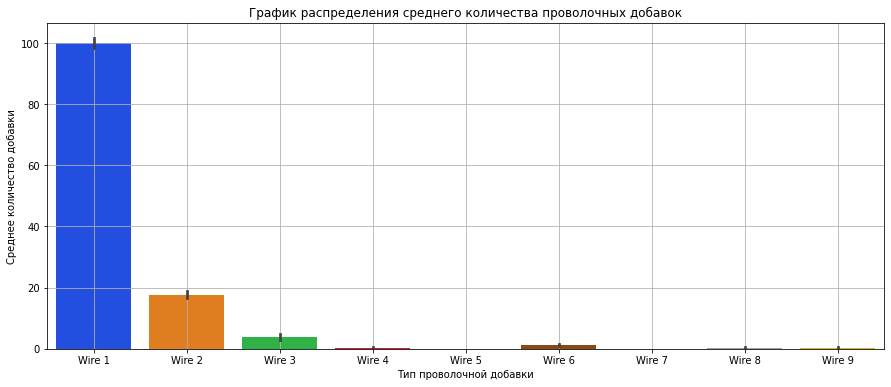

In [32]:
### построим график распределения
plt.figure(figsize=(15,6))
ax_6 = sns.barplot(data=df_6.drop(['key', 'wire_sum'], axis=1), palette='bright')
ax_6.set_xlabel('Тип проволочной добавки')
ax_6.set_ylabel('Среднее количество добавки')
plt.title('График распределения среднего количества проволочных добавок')
plt.grid()
plt.show()

In [33]:
### скорректируем названия колонок, для корректного соединения таблиц в дальнейшем
df_6.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
                'wire_7', 'wire_8', 'wire_9', 'wire_sum']
df_6 = df_6.set_index('key')
df_6.head(1)

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum
key,,,,,,,,,,
1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998


#### Вывод

- В данных очень много пропусков. 
- Добавка из проволочных материалов под номером 5, например, добавлялась лишь в одной партии.
- Пропуск в данных означает отсутсвие добавки.
- Для упрощения расчетов, пропуски заполнены нулем.
- Наибольшее количество проволочных материалов у добавки под номером 1.

### Таблица steel.data_wire_time

In [34]:
### срез для таблицы steel.data_wire_time
query_7 = '''
SELECT *
FROM steel.data_wire_time;
'''
### преобразование в табличную форму библиотеки пандас
df_7 = pd.read_sql_query(query_7, con=engine) 
df_info('steel.data_wire_time', df_7)

'steel.data_wire_time'

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

In [35]:
### проверка на адекватность
df_7 = df_7.fillna(plug)
### создание столбца с максимальным значением в строке
df_7['max_time_wire'] = df_7[df_6_cols].max(axis=1)
### создание столбца с минимальным значением не равным заглушке
def second_min_2(x):
    list_val = []
    for i in range(1, 10):   
        k = x[f'Wire {i}']
        if k != plug:
            list_val.append(k)       
    a = min(list_val)
    return a
df_7['min_time_wire'] = df_7[df_6_cols].apply(second_min_2, axis=1)
df_7['max_time_wire'] = pd.to_datetime(df_7['max_time_wire'].astype(str), format='%H:%M:%S')
df_7['min_time_wire'] = pd.to_datetime(df_7['min_time_wire'].astype(str), format='%H:%M:%S')
df_7['time_dif_sec_wire'] = (df_7['max_time_wire'] - df_7['min_time_wire']).dt.seconds
display(df_7.head(3))
### скорректируем названия колонок, для корректного соединения таблиц в дальнейшем
df_7.columns = ['key', 'wire_1_time', 'wire_2_time', 'wire_3_time', 'wire_4_time', 'wire_5_time', 'wire_6_time',
                'wire_7_time', 'wire_8_time', 'wire_9_time', 'max_time_wire', 'min_time_wire', 'time_dif_sec_wire']
df_7 = df_7.set_index('key')
### выведем строку с максимальным значением для проверки адекватности
max_val_time_dif_2 = df_7['time_dif_sec_wire'].max()
display(df_7.loc[(df_7['time_dif_sec_wire'] == max_val_time_dif_2)])

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,max_time_wire,min_time_wire,time_dif_sec_wire
0,1,11:11:41,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,1900-01-01 11:11:41,1900-01-01 11:11:41,0
1,2,11:46:10,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,1900-01-01 11:46:10,1900-01-01 11:46:10,0
2,3,12:13:47,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,1900-01-01 12:13:47,1900-01-01 12:13:47,0


,wire_1_time,wire_2_time,wire_3_time,wire_4_time,wire_5_time,wire_6_time,wire_7_time,wire_8_time,wire_9_time,max_time_wire,min_time_wire,time_dif_sec_wire
key,,,,,,,,,,,,
745,23:56:02,00:01:56,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,1900-01-01 23:56:02,1900-01-01 00:01:56,86046


#### Вывод

- В данных очень много пропусков, но они идентичны таблице `steel.data_wire`.
- Добавка под номером 5, добавлялась лишь в одной партии, аналогично с предыдущей таблицей.
- Пропуски заполнены заглушкой `00:00:00`.
- Данные проверены на адекватность, наибольшее значение разницы не превышает суток.
- Полученное максимальное значение показало 23 часа между проволочными материалами, но это из-за формата времени без конкретной даты, поэтому все адекватно.

### Объединение признаков

In [36]:
### преобразуем таблицу df_1
df_1_agg_func = {'key'             : 'count', 
                 'begin_heat'      : 'first',
                 'end_heat'        : 'last',
                 'active_power'    : 'mean',
                 'reactive_power'  : 'mean',
                 'cnt_observations': 'count',
                 'time_heat_sec'   : 'sum',
                 'power_diff'      : 'mean',
                 'power_sum'       : 'mean',
                 'div_act_react'   : 'mean'}
df_1_true = df_1.groupby(by=['key']).agg(df_1_agg_func).drop(['cnt_observations'], axis=1)\
                .rename(columns={'key':'cnt_observations'})
### выведем полученный результат
df_1_true.head()

,cnt_observations,begin_heat,end_heat,active_power,reactive_power,time_heat_sec,power_diff,power_sum,div_act_react
key,,,,,,,,,
1,5,1900-01-01 11:02:14,1900-01-01 11:28:37,0.975629,0.636648,1098,0.338981,1.612278,1.538898
2,4,1900-01-01 11:34:14,1900-01-01 11:53:18,0.763150,0.499528,811,0.263622,1.262677,1.551834
3,5,1900-01-01 12:06:54,1900-01-01 12:32:19,0.505176,0.319815,655,0.185361,0.824992,1.583120
4,4,1900-01-01 12:39:37,1900-01-01 12:57:50,0.802313,0.515074,741,0.287238,1.317387,1.563487
5,4,1900-01-01 13:11:13,1900-01-01 13:33:55,0.836793,0.563161,869,0.273633,1.399954,1.480428


In [37]:
### разделим таблицу c данными о температуре на две с начальным и конечным значением (first)
df_5_query_2_first = df_5_query_2.query('str_rank == "first"').set_index('key')
df_5_query_2_first.columns = ['mesaure_time_first', 'temperature_first', 'str_rank']
df_5_query_2_first = df_5_query_2_first[['mesaure_time_first', 'temperature_first']]
df_5_query_2_first.head(3)

,mesaure_time_first,temperature_first
key,,
1,11:16:18,1571.0
2,11:37:27,1581.0
3,12:13:17,1596.0


In [38]:
### разделим таблицу c данными о температуре на две с начальным и конечным значением (last)
df_5_query_2_last = df_5_query_2.query('str_rank == "last"').set_index('key')
df_5_query_2_last.columns = ['mesaure_time_last', 'temperature_last', 'str_rank']
df_5_query_2_last = df_5_query_2_last[['mesaure_time_last', 'temperature_last']]
df_5_query_2_last.head(3)

,mesaure_time_last,temperature_last
key,,
1,11:30:39,1613.0
2,11:59:12,1602.0
3,12:34:57,1599.0


In [39]:
### выведем объединенную таблшицу
df_union = df_1_true.join([df_2, df_3, df_4, df_5_query_2_first, df_5_query_2_last, df_6, df_7], how='inner')
### cбросим ограничения на число столбцов
pd.set_option('display.max_columns', None)
df_union.head(3)

,cnt_observations,begin_heat,end_heat,active_power,reactive_power,time_heat_sec,power_diff,power_sum,div_act_react,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum,bulk_1_time,bulk_2_time,bulk_3_time,bulk_4_time,bulk_5_time,bulk_6_time,bulk_7_time,bulk_8_time,bulk_9_time,bulk_10_time,bulk_11_time,bulk_12_time,bulk_13_time,bulk_14_time,bulk_15_time,max_time_bulk,min_time_bulk,time_dif_sec_bulk,gas,mesaure_time_first,temperature_first,mesaure_time_last,temperature_last,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum,wire_1_time,wire_2_time,wire_3_time,wire_4_time,wire_5_time,wire_6_time,wire_7_time,wire_8_time,wire_9_time,max_time_wire,min_time_wire,time_dif_sec_wire
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5,1900-01-01 11:02:14,1900-01-01 11:28:37,0.975629,0.636648,1098,0.338981,1.612278,1.538898,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,00:00:00,00:00:00,00:00:00,11:21:30,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,11:03:52,00:00:00,11:03:52,11:03:52,1900-01-01 11:21:30,1900-01-01 11:03:52,1058,29.749986,11:16:18,1571.0,11:30:39,1613.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,11:11:41,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,1900-01-01 11:11:41,1900-01-01 11:11:41,0
2,4,1900-01-01 11:34:14,1900-01-01 11:53:18,0.763150,0.499528,811,0.263622,1.262677,1.551834,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,00:00:00,00:00:00,00:00:00,11:46:38,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,11:40:20,00:00:00,11:40:20,11:40:20,1900-01-01 11:46:38,1900-01-01 11:40:20,378,12.555561,11:37:27,1581.0,11:59:12,1602.0,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,11:46:10,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,1900-01-01 11:46:10,1900-01-01 11:46:10,0
3,5,1900-01-01 12:06:54,1900-01-01 12:32:19,0.505176,0.319815,655,0.185361,0.824992,1.583120,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,00:00:00,00:00:00,00:00:00,12:31:06,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,12:09:40,00:00:00,12:09:40,12:09:40,1900-01-01 12:31:06,1900-01-01 12:09:40,1286,28.554793,12:13:17,1596.0,12:34:57,1599.0,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,12:13:47,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,1900-01-01 12:13:47,1900-01-01 12:13:47,0


### Анализ технологического процесса на примере одной партии

In [40]:
### cбросим ограничения на количество выводимых рядов
pd.set_option('display.max_rows', None)
### посмотрим последовательность для партии с номером 17
df_union.loc[17]

cnt_observations                        5
begin_heat            1900-01-01 22:38:42
end_heat              1900-01-01 23:08:15
active_power                     0.535343
reactive_power                   0.387874
time_heat_sec                         714
power_diff                       0.147469
power_sum                        0.923218
div_act_react                    1.384633
bulk_1                                0.0
bulk_2                                0.0
bulk_3                                0.0
bulk_4                                0.0
bulk_5                                0.0
bulk_6                                0.0
bulk_7                                0.0
bulk_8                                0.0
bulk_9                                0.0
bulk_10                               0.0
bulk_11                               0.0
bulk_12                               0.0
bulk_13                               0.0
bulk_14                             153.0
bulk_15                           

**Технологический процесс по обработке стали на примерее партии с номером 17:**
1. Начало нагрева электродами в 22:38:42
2. Измерение температуры в 22:42:34, температура составила 1611.0 градусов
2. Добавление сыпучих добавок под номерами 14 и 15 в 22:46:31, общим объемом 355.0 единиц
3. Добавление проволочных добавок под номером 1 в 22:52:33, объемом 110.2 единиц
4. Добавление проволочных добавок под номером 2 в 23:05:53, объемом 50.1 единиц
6. Конец нагрева электродами в 23:08:15
7. Измерение температуры в 23:10:16, температура составила 1599.0 градусов

#### Вывод

Последовательность технологического процесса для партии 17 совпадает с информацией от заказчика.

### Анализ объединенных признаков

In [41]:
### удаление ненужных столбцов
df_one = df_union.drop(['begin_heat', 'end_heat', 'bulk_1_time', 'bulk_2_time', 'bulk_3_time', 'bulk_4_time', 
                        'bulk_5_time', 'bulk_6_time', 'bulk_7_time', 'bulk_8_time', 'bulk_9_time', 'bulk_10_time', 
                        'bulk_11_time', 'bulk_12_time', 'bulk_13_time', 'bulk_14_time', 'bulk_15_time', 
                        'max_time_bulk', 'min_time_bulk', 'mesaure_time_first', 'mesaure_time_last', 'wire_1_time', 
                        'wire_2_time', 'wire_3_time', 'wire_4_time', 'wire_5_time', 'wire_6_time', 'wire_7_time', 
                        'wire_8_time', 'wire_9_time', 'max_time_wire', 'min_time_wire', 'wire_5'], axis=1)
df_info('Таблица объединенных признаков без информации о времени', df_one)

'Таблица объединенных признаков без информации о времени'

,cnt_observations,active_power,reactive_power,time_heat_sec,power_diff,power_sum,div_act_react,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum,time_dif_sec_bulk,gas,temperature_first,temperature_last,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,wire_sum,time_dif_sec_wire
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5,0.975629,0.636648,1098,0.338981,1.612278,1.538898,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,1058,29.749986,1571.0,1613.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,0
2,4,0.763150,0.499528,811,0.263622,1.262677,1.551834,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,378,12.555561,1581.0,1602.0,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,0
3,5,0.505176,0.319815,655,0.185361,0.824992,1.583120,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,1286,28.554793,1596.0,1599.0,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2499
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cnt_observations   2325 non-null   int64  
 1   active_power       2325 non-null   float64
 2   reactive_power     2325 non-null   float64
 3   time_heat_sec      2325 non-null   int64  
 4   power_diff         2325 non-null   float64
 5   power_sum          2325 non-null   float64
 6   div_act_react      2325 non-null   float64
 7   bulk_1             2325 non-null   float64
 8   bulk_2             2325 non-null   float64
 9   bulk_3             2325 non-null   float64
 10  bulk_4             2325 non-null   float64
 11  bulk_5             2325 non-null   float64
 12  bulk_6             2325 non-null   float64
 13  bulk_7             2325 non-null   float64
 14  bulk_8             2325 non-null   float64
 15  bulk_9             2325 non-null   float64
 16  bulk_10            2325 

'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

In [42]:
### посмотрим корреляцию между всеми признаками и отберем наиболее существенные
df_one_corr = df_one.corr().unstack()[(df_one.corr().unstack() < 1) & (abs(df_one.corr().unstack()) > 0.7)]
df_one_corr

cnt_observations  time_heat_sec       0.798765
active_power      reactive_power      0.922915
                  power_diff          0.731490
                  power_sum           0.985784
reactive_power    active_power        0.922915
                  power_sum           0.974482
time_heat_sec     cnt_observations    0.798765
power_diff        active_power        0.731490
                  div_act_react       0.747631
power_sum         active_power        0.985784
                  reactive_power      0.974482
div_act_react     power_diff          0.747631
bulk_7            wire_4              0.740570
bulk_9            wire_8              0.974968
bulk_12           bulk_sum            0.867932
bulk_sum          bulk_12             0.867932
wire_4            bulk_7              0.740570
wire_8            bulk_9              0.974968
dtype: float64

**Высокая корреляция наблюдается между следующими признаками:**

1.Наименее интересные, изза наличия утечки признака
- активная и реактивная мощность (взаимосвязаны через значение полной мощности)
- активная мощность и суммарная мощность (производный признак)
- реактивная мощность и суммарная мощность (производный признак)
- сыпучая добавка с номером 9 и проволочная добавка с номером 8 (низкое количество добавок в исходных данных)
- сыпучая добавка 12 и суммарное количество добавок (производный признак)

2.Более интересные так как связаны не напрямую
- количество наблюдений и время нагрева
- сыпучая добавка с номером 7 и проволочная добавка с номером 4

In [43]:
### посмотрим общие данные по признакам
df_one.describe()

,cnt_observations,active_power,reactive_power,time_heat_sec,power_diff,power_sum,div_act_react,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum,time_dif_sec_bulk,gas,temperature_first,temperature_last,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,wire_sum,time_dif_sec_wire
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000
mean,4.696344,0.669310,0.499457,808.035269,0.169853,1.168767,1.361584,3.433548,1.424946,47.296774,37.331613,2.644731,22.468817,2.008172,0.021075,0.445591,5.061505,4.252473,208.507957,1.069247,153.971613,120.026667,609.964731,1267.028817,11.378942,1587.365161,1593.366022,102.412198,17.605637,3.240481,0.307077,0.980504,0.006371,0.311847,0.317658,125.181774,327.930753
std,1.605930,0.196986,0.147451,340.829330,0.083257,0.337874,0.132109,12.421994,19.098442,75.228262,58.670377,22.421296,55.831097,30.702509,1.016213,6.225965,20.934742,22.534166,157.137873,14.247231,81.398153,84.674380,287.569669,7587.597740,6.395632,23.623144,11.209581,43.535263,33.642919,27.966585,4.761821,8.700682,0.205882,4.406475,3.459510,63.685486,3994.593048
min,1.000000,0.186226,0.130062,57.000000,-0.376792,0.317899,0.687735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.008399,1519.000000,1541.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.918800,0.000000
25%,4.000000,0.526458,0.392566,581.000000,0.118304,0.921566,1.294044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,440.000000,235.000000,7.282948,1571.000000,1587.000000,73.207679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,89.013596,0.000000
50%,5.000000,0.644934,0.487958,778.000000,0.163787,1.138426,1.373487,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,609.000000,421.000000,10.100950,1587.000000,1593.000000,101.087998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116.101440,0.000000
75%,6.000000,0.792080,0.592560,993.000000,0.219136,1.381760,1.441510,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000,796.000000,758.000000,14.217691,1603.000000,1598.000000,128.069763,23.102560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,151.550872,79.000000
max,16.000000,1.421416,1.134983,4189.000000,0.522428,2.525446,1.955859,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,3235.000000,86198.000000,77.995040,1660.000000,1653.000000,330.314424,282.780152,385.008668,113.231044,180.454575,8.490040,102.762401,62.025600,568.777664,86046.000000


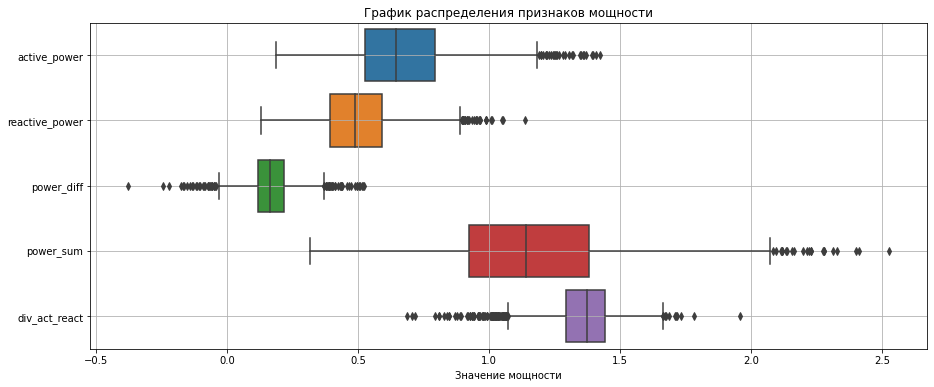

In [44]:
## построим графики распределения признаков
plt.figure(figsize=(15,6))
ax_7 = sns.boxplot(data=df_one[['active_power', 'reactive_power', 'power_diff', 
                                'power_sum', 'div_act_react']], orient='horizontal')
ax_7.set_xlabel('Значение мощности')
plt.title('График распределения признаков мощности')
plt.grid()
plt.show()

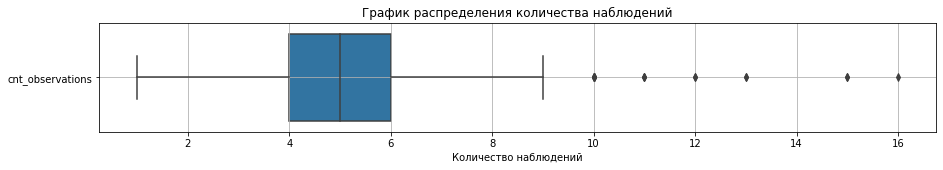

In [45]:
## построим графики распределения признаков
plt.figure(figsize=(15,2))
ax_8 = sns.boxplot(data=df_one[['cnt_observations']], orient='horizontal')
ax_8.set_xlabel('Количество наблюдений')
plt.title('График распределения количества наблюдений')
plt.grid()
plt.show()

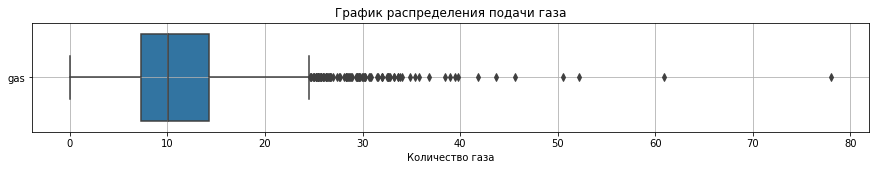

In [46]:
## построим графики распределения признаков
plt.figure(figsize=(15,2))
ax_9 = sns.boxplot(data=df_one[['gas']], orient='horizontal')
ax_9.set_xlabel('Количество газа')
plt.title('График распределения подачи газа')
plt.grid()
plt.show()

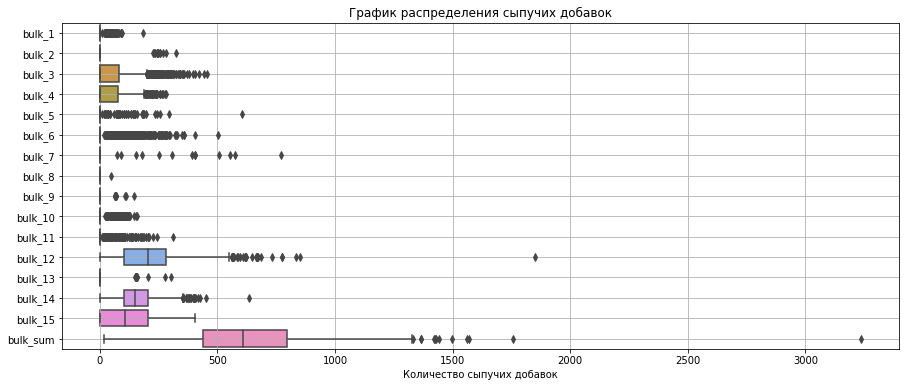

In [47]:
## построим графики распределения признаков
plt.figure(figsize=(15,6))
ax_10 = sns.boxplot(data=df_one[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 
                                'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 
                                'bulk_13', 'bulk_14', 'bulk_15', 'bulk_sum']], orient='horizontal')
ax_10.set_xlabel('Количество сыпучих добавок')
plt.title('График распределения сыпучих добавок')
plt.grid()
plt.show()

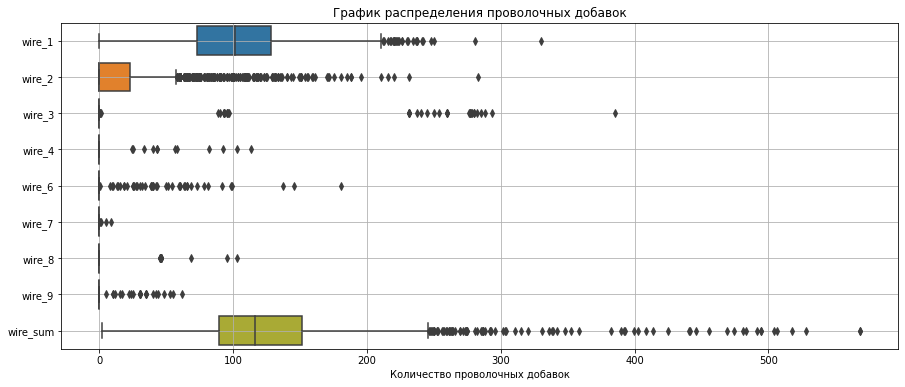

In [48]:
## построим графики распределения признаков
plt.figure(figsize=(15,6))
ax_11 = sns.boxplot(data=df_one[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 
                                'wire_8', 'wire_9', 'wire_sum']], orient='horizontal')
ax_11.set_xlabel('Количество проволочных добавок')
plt.title('График распределения проволочных добавок')
plt.grid()
plt.show()

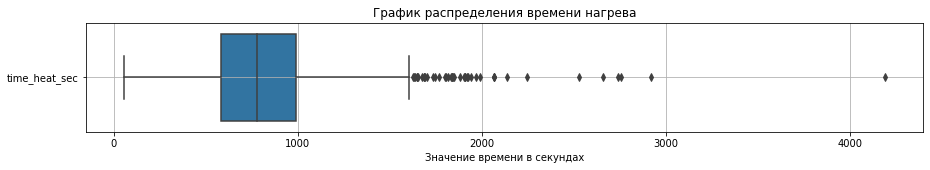

In [49]:
## построим графики распределения признаков
plt.figure(figsize=(15,2))
ax_12 = sns.boxplot(data=df_one[['time_heat_sec']], orient='horizontal')
ax_12.set_xlabel('Значение времени в секундах')
plt.title('График распределения времени нагрева')
plt.grid()
plt.show()

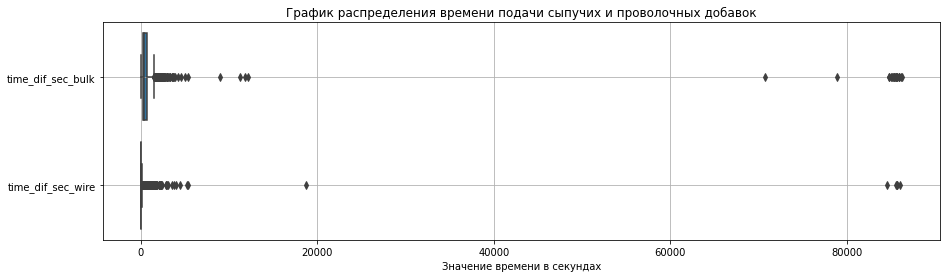

In [50]:
## построим графики распределения признаков
plt.figure(figsize=(15,4))
ax_13 = sns.boxplot(data=df_one[['time_dif_sec_bulk', 'time_dif_sec_wire']], orient='horizontal')
ax_13.set_xlabel('Значение времени в секундах')
plt.title('График распределения времени подачи сыпучих и проволочных добавок')
plt.grid()
plt.show()

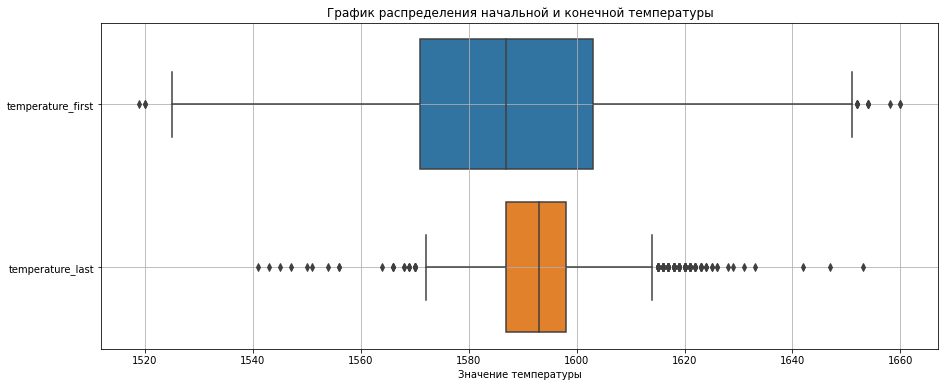

In [51]:
## построим графики распределения признаков
plt.figure(figsize=(15,6))
ax_14 = sns.boxplot(data=df_one[['temperature_first', 'temperature_last']], orient='horizontal')
ax_14.set_xlabel('Значение температуры')
plt.title('График распределения начальной и конечной температуры')
plt.grid()
plt.show()

#### Вывод

- В объединенной таблице признаков пропуски отсутствуют.
- Высокая корреляция на уровне 0.9 наблюдается между признаками, которые или образованы из других признаков, либо имеют схожие черты как минимальные данные об определенных добавках.
- Проволочная добавка под номером 5 удалена, так как после фильтрации единственная партия с данной добавкой была удалена.

## Обучение моделей

### Подготовка признаков перед обучением

In [52]:
### разделим данные на обучающую и тестовую выборки в соотношении 1 к 4
target = df_one['temperature_last']
features = df_one.drop(['temperature_last'], axis=1)
### поделим на выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                            random_state=RANDOM_STATE)
### проверим размерности выборок
display(f'features_train shape: {features_train.shape}')
display(f'target_train shape: {target_train.shape}')
display(f'features_test shape: {features_test.shape}')
display(f'target_test shape: {target_test.shape}')

'features_train shape: (1743, 36)'

'target_train shape: (1743,)'

'features_test shape: (582, 36)'

'target_test shape: (582,)'

In [53]:
### масштабирование признаков
scaler = StandardScaler()
scaler.fit(features_train) 
### преобразуем выборки
features_train = scaler.transform(features_train)                               
features_test = scaler.transform(features_test) 
### уберем предупреждение `SettingWithCopy`
pd.options.mode.chained_assignment = None
### получим заголовки для признаков и скорректируем преобразованные выборки
features_train = pd.DataFrame(features_train, columns = features.columns, index=target_train.index)                                
features_test = pd.DataFrame(features_test, columns = features.columns, index=target_test.index)
### проверим размерности выборок
display(f'features_train shape: {features_train.shape}')
display(f'features_test shape: {features_test.shape}')

'features_train shape: (1743, 36)'

'features_test shape: (582, 36)'

### Модель DummyRegressor

In [54]:
%%time
start_0 = t.time()
### обучим модель DummyRegressor с помощью gridsearch для расчета MAE
# параметры по сетке
parameters_0 = {'strategy': ['median', 'mean']}
dum_reg = DummyRegressor()
clf_0 = GridSearchCV(dum_reg, parameters_0, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, verbose=2)
clf_0.fit(features_train, target_train)
score_0 = abs(clf_0.best_score_)
display(score_0)
display(clf_0.best_params_)
end_0 = t.time() - start_0

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] END ....................................strategy=median; total time=   0.0s
[CV] END ....................................strategy=median; total time=   0.0s
[CV] END ....................................strategy=median; total time=   0.0s
[CV] END ....................................strategy=median; total time=   0.0s
[CV] END ....................................strategy=median; total time=   0.0s
[CV] END ....................................strategy=median; total time=   0.0s
[CV] END ....................................strategy=median; total time=   0.0s
[CV] END ....................................strategy=median; total time=   0.0s
[CV] END ....................................strategy=median; total time=   0.0s
[CV] END ....................................strategy=median; total time=   0.0s
[CV] END ......................................strategy=mean; total time=   0.0s
[CV] END ......................................s

8.138623973727423

{'strategy': 'median'}

CPU times: user 37.6 ms, sys: 125 µs, total: 37.7 ms
Wall time: 35.9 ms


### Модель LinearRegression

In [67]:
### удалим высокороррелирующие признаки для линейной модели
features_train_linear = features_train.drop(['cnt_observations', 'reactive_power', 'power_diff',
                                             'power_sum', 'bulk_7', 'bulk_9', 'bulk_sum'], axis=1)
features_train_linear.head(3)

,active_power,time_heat_sec,div_act_react,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_8,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,time_dif_sec_bulk,gas,temperature_first,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,wire_sum,time_dif_sec_wire
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
170,-0.244338,-0.050177,1.661199,-0.268828,-0.075504,1.990054,-0.633151,-0.131204,5.631237,-0.023959,-0.248116,-0.192524,-0.633274,-0.07639,1.449228,-1.418014,-0.031411,0.942575,0.068985,0.411922,1.944157,-0.11813,-0.064304,-0.116706,-0.033398,-0.081822,-0.086167,1.215735,0.160018
1142,-1.292643,-0.668167,0.127864,-0.268828,-0.075504,2.335438,-0.633151,-0.131204,-0.409159,-0.023959,-0.248116,-0.192524,-0.321183,-0.07639,-0.439751,-0.201746,9.847339,2.887817,0.784705,-0.222401,-0.527455,-0.11813,-0.064304,-0.116706,-0.033398,-0.081822,-0.086167,-0.513007,-0.082537
548,1.684358,0.898775,1.826674,-0.268828,-0.075504,-0.055682,-0.633151,-0.131204,1.126828,-0.023959,-0.248116,-0.192524,-0.639643,-0.07639,1.290797,-1.418014,-0.059145,0.717900,-2.457085,-0.961313,-0.527455,-0.11813,-0.064304,-0.116706,-0.033398,-0.081822,-0.086167,-1.008245,-0.082537


In [68]:
%%time
start_1 = t.time()
### обучим модель LinearRegression с помощью gridsearch для расчета MAE
# параметры по сетке
parameters_1 = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}
lin_reg = LinearRegression()
clf_1 = GridSearchCV(lin_reg, parameters_1, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, verbose=2)
clf_1.fit(features_train_linear, target_train)
score_1 = abs(clf_1.best_score_)
display(score_1)
display(clf_1.best_params_)
end_1 = t.time() - start_1

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END .................fit_intercept=True, positive=False; total time=   0.0s
[CV] END .................fit_intercept=True, po

6.5883385678144375

{'fit_intercept': True, 'positive': True}

CPU times: user 754 ms, sys: 877 ms, total: 1.63 s
Wall time: 1.64 s


### Модель RandomForestRegressor

In [56]:
%%time
start_2 = t.time()
### обучим модель RandomForestRegressor с помощью gridsearch для расчета MAE
# параметры по сетке
parameters_2 = {
    'n_estimators': [10, 30],
    'max_depth': [5, 10],
    'min_samples_leaf': [6, 7]
}
ran_for = RandomForestRegressor(random_state=RANDOM_STATE)
clf_2 = GridSearchCV(ran_for, parameters_2, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, verbose=2)
clf_2.fit(features_train, target_train)
score_2 = abs(clf_2.best_score_)
display(score_2)
display(clf_2.best_params_)
end_2 = t.time() - start_2

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=10; total time=   0.2s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=10; total time=   0.1s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=10; total time=   0.1s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=10; total time=   0.1s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=10; total time=   0.1s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=10; total time=   0.1s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=10; total time=   0.1s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=10; total time=   0.1s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=10; total time=   0.1s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=10; total time=   0.1s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=30; total time=   0.2s
[CV] END ...max_depth=5, min_samples_leaf=6, n_e

6.184246526451936

{'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 30}

CPU times: user 15 s, sys: 40.4 ms, total: 15 s
Wall time: 15.2 s


### Модель LGBMRegressor

In [57]:
%%time
start_3 = t.time()
### обучим модель LGBMRegressor с помощью gridsearch для расчета MAE
## параметры по сетке
parameters_3 = {
    'n_estimators' : [10, 30],
    'learning_rate' : [0.05, 0.1]
}
lgb_reg = LGBMRegressor(random_state=RANDOM_STATE)
clf_3 = GridSearchCV(lgb_reg, parameters_3, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, verbose=2)
clf_3.fit(features_train, target_train)
score_3 = abs(clf_3.best_score_)
display(score_3)
display(clf_3.best_params_)
end_3 = t.time() - start_3

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] END ................learning_rate=0.05, n_estimators=10; total time=   0.2s
[CV] END ................learning_rate=0.05, n_estimators=10; total time=   0.4s
[CV] END ................learning_rate=0.05, n_estimators=10; total time=   0.2s
[CV] END ................learning_rate=0.05, n_estimators=10; total time=   0.3s
[CV] END ................learning_rate=0.05, n_estimators=10; total time=   0.3s
[CV] END ................learning_rate=0.05, n_estimators=10; total time=   0.2s
[CV] END ................learning_rate=0.05, n_estimators=10; total time=   0.2s
[CV] END ................learning_rate=0.05, n_estimators=10; total time=   0.3s
[CV] END ................learning_rate=0.05, n_estimators=10; total time=   0.2s
[CV] END ................learning_rate=0.05, n_estimators=10; total time=   0.4s
[CV] END ................learning_rate=0.05, n_estimators=30; total time=   0.4s
[CV] END ................learning_rate=0.05, n_e

6.0767576927195615

{'learning_rate': 0.1, 'n_estimators': 30}

CPU times: user 16.3 s, sys: 67.2 ms, total: 16.3 s
Wall time: 16.4 s


### Модель CatBoostRegressor

In [58]:
%%time
start_4 = t.time()
### обучим модель CatBoostRegressor с помощью gridsearch для расчета MAE
### параметры по сетке
parameters_4 = {
    'depth' : [5, 10],
    'iterations' : [1000, 1500]
}
cbc_reg = CatBoostRegressor(random_state=RANDOM_STATE, learning_rate=0.02, verbose=500)
clf_4 = GridSearchCV(cbc_reg, parameters_4, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, verbose=2)
clf_4.fit(features_train, target_train)
score_4 = abs(clf_4.best_score_)
display(score_4)
display(clf_4.best_params_)
end_4 = t.time() - start_4

Fitting 10 folds for each of 4 candidates, totalling 40 fits
0:	learn: 11.2334700	total: 49.7ms	remaining: 49.7s
500:	learn: 6.5125431	total: 1.37s	remaining: 1.36s
999:	learn: 5.3972442	total: 2.66s	remaining: 0us
[CV] END ...........................depth=5, iterations=1000; total time=   3.4s
0:	learn: 11.2609119	total: 3.05ms	remaining: 3.04s
500:	learn: 6.4428666	total: 1.29s	remaining: 1.29s
999:	learn: 5.2936326	total: 2.61s	remaining: 0us
[CV] END ...........................depth=5, iterations=1000; total time=   3.4s
0:	learn: 11.1519329	total: 3.49ms	remaining: 3.49s
500:	learn: 6.2712726	total: 1.37s	remaining: 1.37s
999:	learn: 5.1594195	total: 2.76s	remaining: 0us
[CV] END ...........................depth=5, iterations=1000; total time=   3.7s
0:	learn: 11.2695552	total: 3.08ms	remaining: 3.08s
500:	learn: 6.3624018	total: 1.32s	remaining: 1.31s
999:	learn: 5.2237148	total: 2.64s	remaining: 0us
[CV] END ...........................depth=5, iterations=1000; total time=   3.3s

5.857465471251567

{'depth': 5, 'iterations': 1500}

CPU times: user 19min 35s, sys: 4.76 s, total: 19min 40s
Wall time: 20min 25s


### Модель KerasRegressor

In [59]:
### определим базовую модель
def Base_Model():
    model = Sequential()
    model.add(Dense(1024, input_dim=features_train.shape[1], activation='relu')) 
    model.add(Dense(1024, activation='elu'))
    model.add(Dense(1024, activation='selu')) 
    model.add(Dense(1024, activation='elu')) 
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')   
    return model
### посмотрим схему модели
Base_Model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              37888     
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3,187,713
Trainable params: 3,187,713
Non-trainable params: 0
_________________________________________________________________


2023-07-08 11:39:02.629075: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [60]:
%%time
start_5 = t.time()
### зафиксируем рандом
tf.random.set_seed(RANDOM_STATE)
### обучим модель KerasRegressor с помощью gridsearch для расчета MAE
### параметры по сетке
parameters_5 = {
    'nb_epoch' : [30, 50],
    'batch_size' : [3, 5]
}
ker_reg = KerasRegressor(build_fn=Base_Model)
clf_5 = GridSearchCV(ker_reg, parameters_5, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, verbose=2)
clf_5.fit(features_train, target_train)
score_5 = abs(clf_5.best_score_)
display(score_5)
display(clf_5.best_params_)
end_5 = t.time() - start_5

<timed exec>:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


Fitting 10 folds for each of 4 candidates, totalling 40 fits
523/523 [==============================] - 20s 36ms/step - loss: 56614.8555
[CV] END ..........................batch_size=3, nb_epoch=30; total time=  20.8s
523/523 [==============================] - 19s 36ms/step - loss: 56996.4375
[CV] END ..........................batch_size=3, nb_epoch=30; total time=  20.1s
523/523 [==============================] - 19s 36ms/step - loss: 57266.8945
[CV] END ..........................batch_size=3, nb_epoch=30; total time=  19.8s
523/523 [==============================] - 19s 36ms/step - loss: 64198.9180
[CV] END ..........................batch_size=3, nb_epoch=30; total time=  20.1s
523/523 [==============================] - 19s 36ms/step - loss: 60420.8398
[CV] END ..........................batch_size=3, nb_epoch=30; total time=  20.3s
523/523 [==============================] - 19s 36ms/step - loss: 57132.9414
[CV] END ..........................batch_size=3, nb_epoch=30; total time=  19.

11.123427473797978

{'batch_size': 3, 'nb_epoch': 30}

CPU times: user 9min 17s, sys: 1min 12s, total: 10min 30s
Wall time: 10min 47s


### Итоги обучения

In [69]:
### выведем результаты как таблицу с данными
total_row_0 = ['mae', score_0, score_1, score_2, score_3, score_4, score_5]
total_row_1 = ['time_learn, min', end_0/60, end_1/60, end_2/60, end_3/60, end_4/60, end_5/60]
data_temp_scores = pd.DataFrame([total_row_0, total_row_1])
data_temp_scores.columns = ['Metrics', 'DummyRegressor', 'LinearRegression', 'RandomForestRegressor', 'LGBMRegressor', 
                            'CatBoostRegressor', 'KerasRegressor']
display(data_temp_scores.set_index('Metrics'))

,DummyRegressor,LinearRegression,RandomForestRegressor,LGBMRegressor,CatBoostRegressor,KerasRegressor
Metrics,,,,,,
mae,8.138624,6.588339,6.184247,6.076758,5.857465,11.123427
"time_learn, min",0.000597,0.027269,0.253201,0.273208,20.418501,10.786504


#### Вывод

Лучшая модель - модель CatBoostRegressor, с показателем метрики МАЕ равным 5.857, но достаточно длительным временем обучения, порядка 20 минут. Для теста будем использовать именно эту модель.

### Тестирование лучшей модели

In [62]:
### проведем тестирование, метрика МАЕ должна быть не выше 6,8
cbc_reg_test = CatBoostRegressor(random_state=RANDOM_STATE, learning_rate=0.02, depth=5, iterations=1500, verbose=500)
cbc_reg_test.fit(features_train, target_train)
predictions = cbc_reg_test.predict(features_test)
score_test_mae = round(mean_absolute_error(target_test, predictions), 3)
score_test_r2 = round(r2_score(target_test, predictions), 3)
display(f'Значение метрики МАЕ, на тестовой выборке составляет: {score_test_mae}')
display(f'Значение метрики R2, на тестовой выборке составляет: {score_test_r2}')

0:	learn: 11.2570424	total: 3.31ms	remaining: 4.96s
500:	learn: 6.5416557	total: 1.35s	remaining: 2.69s
1000:	learn: 5.4553680	total: 2.7s	remaining: 1.35s
1499:	learn: 4.7654921	total: 4.04s	remaining: 0us


'Значение метрики МАЕ, на тестовой выборке составляет: 5.771'

'Значение метрики R2, на тестовой выборке составляет: 0.499'

#### Вывод

- Значение метрики МАЕ ниже 6.8 и составляет 5.771, задача тестирования выполнена верно. 
- Значение метрики R2 равно 0.5, что говорит о точности модели на уровне 50%

### Анализ наиболее важных признаков для обучения модели

In [63]:
### создадим функцию отображения наиболее важных параметров для обучения
def features_importances_plot(features_importances, features_names, model_name):
    feat_importances = pd.Series(features_importances, index=features_names).sort_values(ascending=False)
    plt.figure(figsize=(15,5))
    sns.barplot(x=feat_importances.index, y=feat_importances.values)
    plt.grid()
    plt.title(f'Наиболее значимые признаки для модели {model_name}')
    plt.xticks(rotation=90);

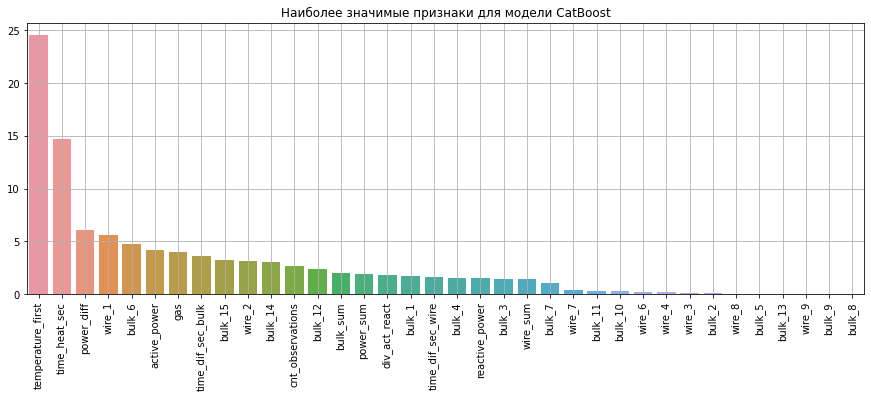

In [64]:
### применим функцию для модели CatBoost
features_importances_plot(features_importances=cbc_reg_test.feature_importances_, 
                          features_names=features_train.columns, model_name='CatBoost')

#### Вывод

В графике видны два наиболее важных параметра для обучения модели, это начальная температура и время нагрева электродами в секундах. Остальные параметры наименее важные.